In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from kdg import kdn, kdcnn
from kdg.utils import generate_gaussian_parity, hellinger, plot_2dsim, generate_ood_samples, sample_unifrom_circle, get_ece
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from joblib import Parallel, delayed
from scipy.io import savemat, loadmat
from sklearn.metrics import roc_auc_score
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import activations
from tensorflow.keras import backend as bknd
import timeit

### Visualize the data

<AxesSubplot: >

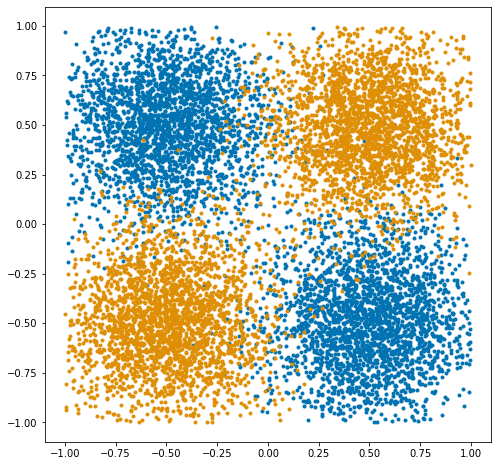

In [2]:
X, y = generate_gaussian_parity(10000)
plot_2dsim(X, y)

In [3]:
compile_kwargs = {
        "loss": "binary_crossentropy",
        "optimizer": keras.optimizers.Adam(3e-4),
    }
callback = keras.callbacks.EarlyStopping(monitor="loss", patience=10, verbose=True)
fit_kwargs = {
        "epochs": 200,
        "batch_size": 64,
        "verbose": False,
        "callbacks": [callback],
    }

In [4]:
# network architecture [1000, 1000, 1000, 1000, 2]
def getNN(input_size, num_classes):
    network_base = keras.Sequential()
    initializer = keras.initializers.random_normal(seed=0)
    network_base.add(keras.layers.Dense(1000, kernel_initializer=initializer, input_shape=(input_size,)))
    network_base.add(keras.layers.Activation(activations.relu))
    network_base.add(keras.layers.Dense(1000, kernel_initializer=initializer))
    network_base.add(keras.layers.Activation(activations.relu))
    network_base.add(keras.layers.Dense(1000, kernel_initializer=initializer))
    network_base.add(keras.layers.Activation(activations.relu))
    network_base.add(keras.layers.Dense(1000, kernel_initializer=initializer))
    network_base.add(keras.layers.Activation(activations.relu))
    network_base.add(keras.layers.Dense(units=num_classes, activation="softmax", kernel_initializer=initializer))
    network_base.compile(**compile_kwargs)
    return network_base

In [5]:
# train Vanilla NN
nn = getNN(input_size=2, num_classes=2)
history = nn.fit(X, keras.utils.to_categorical(y), **fit_kwargs)

Metal device set to: Apple M1 Max


2023-09-01 08:36:20.789391: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-09-01 08:36:20.789530: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-09-01 08:36:20.921549: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-09-01 08:36:21.113421: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 31: early stopping


### Calculate posteriors and likelihoods using KDN

In [6]:
df = {}

t_0 = timeit.default_timer()
model_kdn = kdn(network=nn)
model_kdn.fit(X, y, k=2e8)
t_1 = timeit.default_timer()

print(f"Elapsed time: {t_1-t_0} s")
#define grids
p = np.arange(-2, 2, step=0.01)
q = np.arange(-2, 2, step=0.01)
xx, yy = np.meshgrid(p, q)

grid_samples = np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1)), axis=1)
posterior_nn = model_kdn.network.predict(grid_samples)
posterior_kdn, likelihoods_kdn = model_kdn.predict_proba(grid_samples, return_likelihood=True)
posterior_kdn_geod, likelihoods_kdn_geod = model_kdn.predict_proba(grid_samples, distance='Geodesic', return_likelihood=True)

posterior_nn = posterior_nn[:,0].reshape(400,400)
posterior_kdn = posterior_kdn[:,0].reshape(400,400)
class1_likelihoods = likelihoods_kdn[:,0].reshape(400,400)
class2_likelihoods = likelihoods_kdn[:,1].reshape(400,400)

posterior_kdn_geod = posterior_kdn_geod[:,0].reshape(400,400)
class1_likelihoods_geod = likelihoods_kdn_geod[:,0].reshape(400,400)
class2_likelihoods_geod = likelihoods_kdn_geod[:,1].reshape(400,400)

df['posterior_dn'] = posterior_nn
df['posterior_kdn'] = posterior_kdn
df['likelihood_class1'] = class1_likelihoods
df['likelihood_class2'] = class2_likelihoods
df['posterior_kdn_geod'] = posterior_kdn_geod
df['likelihood_class1_geod'] = class1_likelihoods_geod
df['likelihood_class2_geod'] = class2_likelihoods_geod

Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:59<00:00, 11.99s/it]


Elapsed time: 66.594433458 s
  85/5000 [..............................] - ETA: 8s

2023-09-01 08:37:59.768471: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5000/5000 [==============================] - 9s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:57<00:00, 71.44s/it]


Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:42<00:00, 68.47s/it]


Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:42<00:00, 68.44s/it]


Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:34<00:00, 66.91s/it]


In [7]:
# get true posterior
tp_df = pd.read_csv("../true_posterior/Gaussian_xor_pdf.csv")
proba_true = 0.5*np.ones((400, 400))
tmp = np.array([tp_df["posterior"][x] for x in range(40000)])
tmp = np.flip(tmp.reshape(200, 200), axis=1)
proba_true[100:300, 100:300] = 1 - tmp
#df["true_proba"] = proba_true

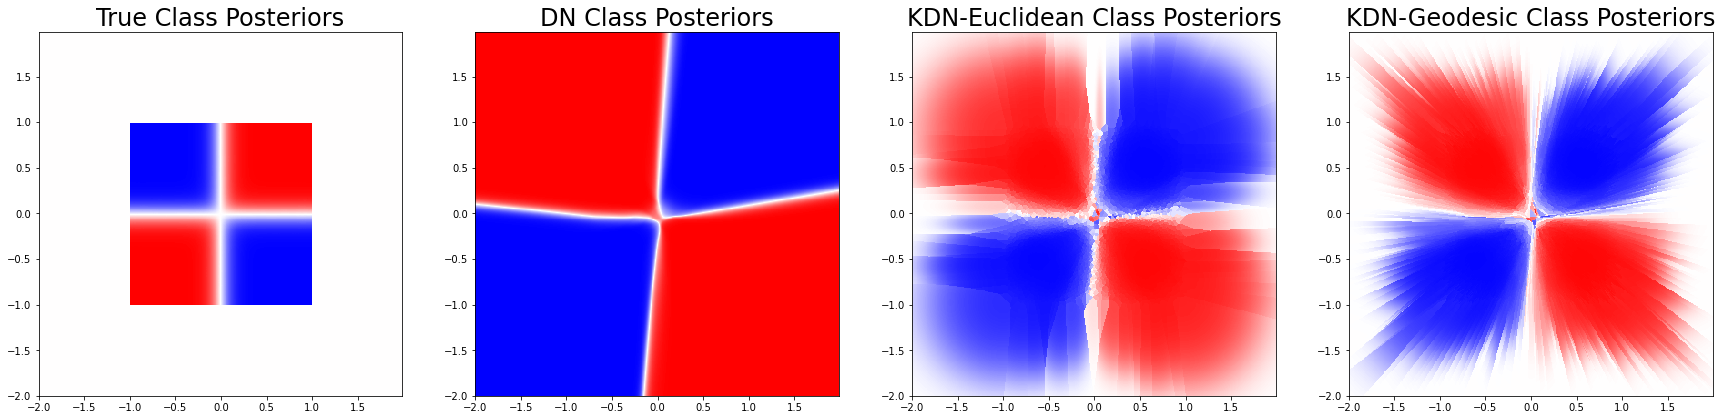

In [8]:
fig1, ax = plt.subplots(1, 4, figsize=(30, 150))

ax0 = ax[0].imshow(
    proba_true,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[0].set_title("True Class Posteriors", fontsize=24)
ax[0].set_aspect("equal")

ax1 = ax[1].imshow(
    1-posterior_nn,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[1].set_title("DN Class Posteriors", fontsize=24)
ax[1].set_aspect("equal")

ax2 = ax[2].imshow(
    1-posterior_kdn,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[2].set_title("KDN-Euclidean Class Posteriors", fontsize=24)
ax[2].set_aspect("equal")

ax2 = ax[3].imshow(
    1-posterior_kdn_geod,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[3].set_title("KDN-Geodesic Class Posteriors", fontsize=24)
ax[3].set_aspect("equal")
plt.show()

### Visualize class likelihoods

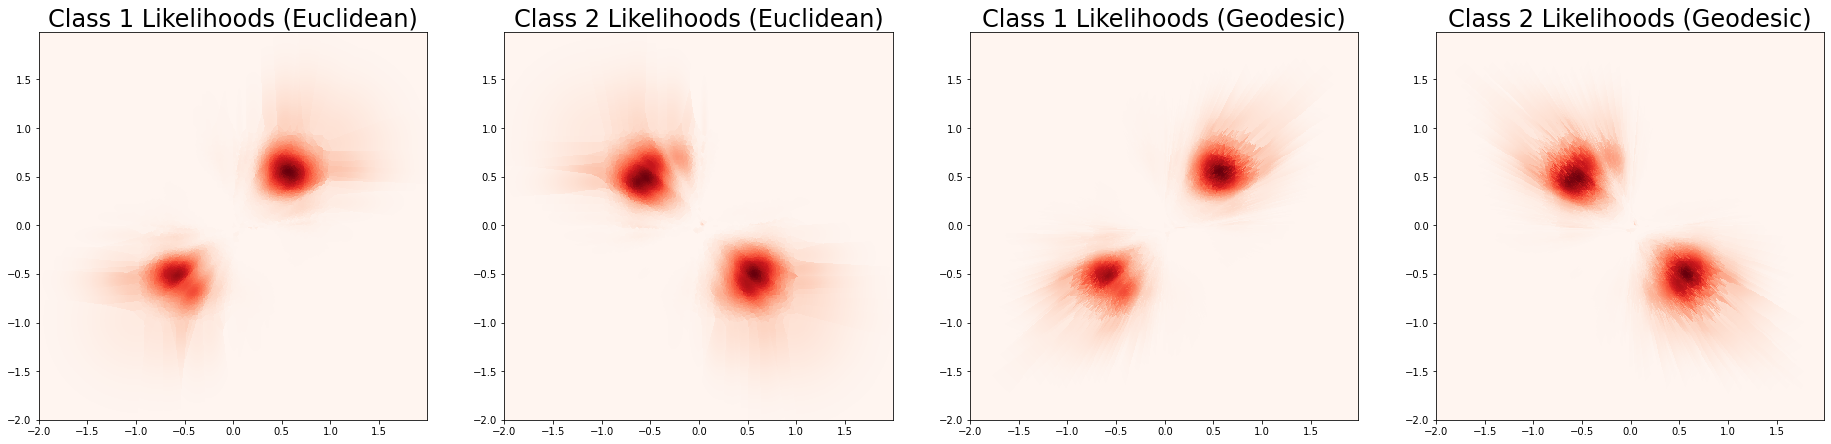

In [9]:
fig1, ax = plt.subplots(1, 4, figsize=(32, 8))

ax0 = ax[0].imshow(
    class1_likelihoods,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="Reds",
    interpolation="nearest",
    aspect="auto",
)
ax[0].set_title("Class 1 Likelihoods (Euclidean)", fontsize=24)
ax[0].set_aspect("equal")


ax1 = ax[1].imshow(
    class2_likelihoods,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="Reds",
    interpolation="nearest",
    aspect="auto",
)
ax[1].set_title("Class 2 Likelihoods (Euclidean)", fontsize=24)
ax[1].set_aspect("equal")

ax2 = ax[2].imshow(
    class1_likelihoods_geod,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="Reds",
    interpolation="nearest",
    aspect="auto",
)
ax[2].set_title("Class 1 Likelihoods (Geodesic)", fontsize=24)
ax[2].set_aspect("equal")

ax3 = ax[3].imshow(
    class2_likelihoods_geod,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="Reds",
    interpolation="nearest",
    aspect="auto",
)
ax[3].set_title("Class 2 Likelihoods (Geodesic)", fontsize=24)
ax[3].set_aspect("equal")

### Experiment with misclassification error and hellinger distance

In [10]:
mc_reps = 10
sample_size = [50, 100, 500, 1000, 5000, 10000]
n_test = 1000

tp_df = pd.read_csv("../true_posterior/Gaussian_xor_pdf.csv")
true_posterior = tp_df['posterior']
true_posterior = np.vstack((true_posterior.ravel(), 1-true_posterior.ravel())).T
        
    
def experiment_in(sample, n_test, true_posterior):
    X, y = generate_gaussian_parity(sample)
    X_test, y_test = generate_gaussian_parity(n_test)

    p = np.arange(-1, 1, step=0.01)
    q = np.arange(-1, 1, step=0.01)
    xx, yy = np.meshgrid(p, q)

    grid_samples = np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1)), axis=1)

    nn = getNN(input_size=2, num_classes=2)
    history = nn.fit(X, keras.utils.to_categorical(y), **fit_kwargs)
    model_kdn = kdn(network=nn)
    model_kdn.fit(X, y, k=2e8)

    error_kdn = 1 - np.mean(model_kdn.predict(X_test)==y_test)
    error_kdn_geod = 1 - np.mean(model_kdn.predict(X_test, distance='Geodesic')==y_test)
    error_dn = 1 - np.mean(np.argmax(model_kdn.network.predict(X_test),axis=1)==y_test)
    
    proba_kdn = model_kdn.predict_proba(grid_samples)
    proba_kdn_geod = model_kdn.predict_proba(grid_samples, distance='Geodesic')
    proba_dn = model_kdn.network.predict(grid_samples)
    
    hellinger_dis_kdn = hellinger(true_posterior, proba_kdn)
    hellinger_dis_kdn_geod = hellinger(true_posterior, proba_kdn_geod)
    hellinger_dis_dn = hellinger(true_posterior, proba_dn)
    
    
    return error_kdn, error_kdn_geod, error_dn, hellinger_dis_kdn, hellinger_dis_kdn_geod, hellinger_dis_dn

def experiment_out(in_sample, r, n_test):
    mmcOut_dn = np.zeros(len(r),dtype=float)
    mmcOut_kdn = np.zeros(len(r),dtype=float)
    mmcOut_kdn_geod = np.zeros(len(r),dtype=float)
    
    X, y = generate_gaussian_parity(in_sample)
    nn = getNN(input_size=2, num_classes=2)
    history = nn.fit(X, keras.utils.to_categorical(y), **fit_kwargs)
    
    model_kdn = kdn(network=nn)
    model_kdn.fit(X, y, k=1e3)
    
    for ii, r_ in enumerate(r):
        X_ood = sample_unifrom_circle(n=n_test, r=r_)
        mmcOut_dn[ii] = np.mean(np.max(
            model_kdn.network.predict(X_ood), axis=1
            )
        )
        mmcOut_kdn[ii] = np.mean(np.max(model_kdn.predict_proba(X_ood), axis=1))
        mmcOut_kdn_geod[ii] = np.mean(np.max(model_kdn.predict_proba(X_ood, distance='Geodesic'), axis=1))
    
    return mmcOut_kdn, mmcOut_kdn_geod, mmcOut_dn
        
    
error_kdn_med = []
error_kdn_25 = []
error_kdn_75 = []
error_kdn_geod_med = []
error_kdn_geod_25 = []
error_kdn_geod_75 = []
error_dn_med = []
error_dn_25 = []
error_dn_75 = []

hellinger_kdn_med = []
hellinger_kdn_25 = []
hellinger_kdn_75 = []
hellinger_kdn_geod_med = []
hellinger_kdn_geod_25 = []
hellinger_kdn_geod_75 = []
hellinger_dn_med = []
hellinger_dn_25 = []
hellinger_dn_75 = []


mmcOut_kdn_med = []
mmcOut_kdn_25 = []
mmcOut_kdn_75 = []
mmcOut_kdn_geod_med = []
mmcOut_kdn_geod_25 = []
mmcOut_kdn_geod_75 = []
mmcOut_dn_med = []
mmcOut_dn_25 = []
mmcOut_dn_75 = []


#### do out-of-distribution results ####
r = np.arange(0,10.5,.5)
mmcOut_kdn = np.zeros((len(r),mc_reps), dtype=float)
mmcOut_kdn_geod = np.zeros((len(r),mc_reps), dtype=float)
mmcOut_dn = np.zeros((len(r),mc_reps), dtype=float)

for rep in range(mc_reps):
    mmcOut_kdn[:,rep], mmcOut_kdn_geod[:,rep], mmcOut_dn[:,rep] = experiment_out(1000, r, n_test)
    
    
mmcOut_kdn_med = np.median(mmcOut_kdn, axis=1)
mmcOut_kdn_25 = np.quantile(mmcOut_kdn, [0.25], axis=1)
mmcOut_kdn_75 = np.quantile(mmcOut_kdn, [0.75], axis=1)

mmcOut_kdn_geod_med = np.median(mmcOut_kdn_geod, axis=1)
mmcOut_kdn_geod_25 = np.quantile(mmcOut_kdn_geod, [0.25], axis=1)
mmcOut_kdn_geod_75 = np.quantile(mmcOut_kdn_geod, [0.75], axis=1)

mmcOut_dn_med = np.median(mmcOut_dn, axis=1)
mmcOut_dn_25 = np.quantile(mmcOut_dn, [0.25], axis=1)
mmcOut_dn_75 = np.quantile(mmcOut_dn, [0.75], axis=1)
    
        
#### do in-distribution results ####
for sample in sample_size:
    err_kdn = []
    err_kdn_geod = []
    err_dn = []
    hellinger_kdn = []
    hellinger_kdn_geod = []
    hellinger_dn = []
    
    for ii in range(mc_reps):
        a,b,c,d,e,f = experiment_in(sample, n_test, true_posterior) 
        
        err_kdn.append(a)
        err_kdn_geod.append(b)
        err_dn.append(c)
        hellinger_kdn.append(d)
        hellinger_kdn_geod.append(e)
        hellinger_dn.append(f)
        

    error_kdn_med.append(
        np.median(err_kdn)
    )
    error_kdn_25.append(
        np.quantile(err_kdn, [0.25])[0]
    )
    error_kdn_75.append(
        np.quantile(err_kdn, [0.75])[0]
    )
    
    error_kdn_geod_med.append(
        np.median(err_kdn_geod)
    )
    error_kdn_geod_25.append(
        np.quantile(err_kdn_geod, [0.25])[0]
    )
    error_kdn_geod_75.append(
        np.quantile(err_kdn_geod, [0.75])[0]
    )
    
    error_dn_med.append(
        np.median(err_dn)
    )
    error_dn_25.append(
        np.quantile(err_dn, [0.25])[0]
    )
    error_dn_75.append(
        np.quantile(err_dn, [0.75])[0]
    )
    
    
    hellinger_kdn_med.append(
        np.median(hellinger_kdn)
    )
    hellinger_kdn_25.append(
        np.quantile(hellinger_kdn, [0.25])[0]
    )
    hellinger_kdn_75.append(
        np.quantile(hellinger_kdn, [0.75])[0]
    )
    
    hellinger_kdn_geod_med.append(
        np.median(hellinger_kdn_geod)
    )
    hellinger_kdn_geod_25.append(
        np.quantile(hellinger_kdn_geod, [0.25])[0]
    )
    hellinger_kdn_geod_75.append(
        np.quantile(hellinger_kdn_geod, [0.75])[0]
    )
    
    hellinger_dn_med.append(
        np.median(hellinger_dn)
    )
    hellinger_dn_25.append(
        np.quantile(hellinger_dn, [0.25])[0]
    )
    hellinger_dn_75.append(
        np.quantile(hellinger_dn, [0.75])[0]
    )
    
    

df['error_kdn_med'] = error_kdn_med
df['error_kdn_25'] = error_kdn_25
df['error_kdn_75'] = error_kdn_75

df['error_kdn_geod_med'] = error_kdn_geod_med
df['error_kdn_geod_25'] = error_kdn_geod_25
df['error_kdn_geod_75'] = error_kdn_geod_75

df['error_dn_med'] = error_dn_med
df['error_dn_25'] = error_dn_25
df['error_dn_75'] = error_dn_75

df['hellinger_kdn_med'] = hellinger_kdn_med
df['hellinger_kdn_25'] = hellinger_kdn_25
df['hellinger_kdn_75'] = hellinger_kdn_75

df['hellinger_kdn_geod_med'] = hellinger_kdn_geod_med
df['hellinger_kdn_geod_25'] = hellinger_kdn_geod_25
df['hellinger_kdn_geod_75'] = hellinger_kdn_geod_75

df['hellinger_dn_med'] = hellinger_dn_med
df['hellinger_dn_25'] = hellinger_dn_25
df['hellinger_dn_75'] = hellinger_dn_75

df['mmcOut_kdn_med'] = mmcOut_kdn_med
df['mmcOut_kdn_25'] = mmcOut_kdn_25
df['mmcOut_kdn_75'] = mmcOut_kdn_75

df['mmcOut_kdn_geod_med'] = mmcOut_kdn_geod_med
df['mmcOut_kdn_geod_25'] = mmcOut_kdn_geod_25
df['mmcOut_kdn_geod_75'] = mmcOut_kdn_geod_75

df['mmcOut_dn_med'] = mmcOut_dn_med
df['mmcOut_dn_25'] = mmcOut_dn_25
df['mmcOut_dn_75'] = mmcOut_dn_75

2023-09-01 09:01:28.292878: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 27: early stopping
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


 1/32 [..............................] - ETA: 1s

2023-09-01 09:01:32.069295: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.39it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.10it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.84it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.53it/s]
2023-09-01 09:01:49.556241: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 130: early stopping
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


 1/32 [..............................] - ETA: 1s

2023-09-01 09:02:03.700969: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.40it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]
2023-09-01 09:02:21.072787: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 78: early stopping
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.54it/s]


 1/32 [..............................] - ETA: 1s

2023-09-01 09:02:30.039751: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.97it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]

32/32 [==============================] - 0s 2ms/step


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.50it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.36it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.35it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.25it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.09it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.06it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.32it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.97it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.60it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.52it/s]
2023-09-01 09:02:47.738008: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 116: early stopping
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


29/32 [==========================>...] - ETA: 0s

2023-09-01 09:03:00.547631: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.94it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.05it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.55it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.86it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.50it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.20it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]
2023-09-01 09:03:17.688022: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 59: early stopping
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.00it/s]


 1/32 [..............................] - ETA: 1s

2023-09-01 09:03:24.811175: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.30it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.80it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.89it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.89it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.82it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.68it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.83it/s]
2023-09-01 09:03:42.088935: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 59: early stopping
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]


29/32 [==========================>...] - ETA: 0s

2023-09-01 09:03:49.156764: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.51it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.19it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.58it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.04it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.28it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.96it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.59it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.74it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.76it/s]
2023-09-01 09:04:06.458078: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 39: early stopping
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]


 1/32 [..............................] - ETA: 1s

2023-09-01 09:04:11.503352: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.42it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.69it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.53it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.73it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.34it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.79it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.61it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.77it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.83it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.04it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.95it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.22it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.25it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.64it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.76it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.68it/s]
2023-09-01 09:04:28.922060: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 26: early stopping
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.68it/s]


 1/32 [..............................] - ETA: 1s

2023-09-01 09:04:32.663828: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.85it/s]

32/32 [==============================] - 0s 2ms/step


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]

32/32 [==============================] - 0s 2ms/step


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.20it/s]

32/32 [==============================] - 0s 2ms/step


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.55it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.26it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.90it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.93it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.74it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.41it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.81it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.64it/s]

32/32 [==============================] - 0s 2ms/step


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.94it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.38it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.46it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.57it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.62it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.64it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.37it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.89it/s]
2023-09-01 09:04:51.141588: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 76: early stopping
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.33it/s]

 1/32 [..............................] - ETA: 1s


2023-09-01 09:05:00.143683: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.83it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.04it/s]

32/32 [==============================] - 0s 2ms/step


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.44it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.23it/s]

32/32 [==============================] - 0s 2ms/step


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.50it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.13it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.42it/s]

32/32 [==============================] - 0s 2ms/step


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.95it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.27it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.01it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.68it/s]

32/32 [==============================] - 0s 2ms/step


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.44it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.75it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.75it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.60it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.74it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.48it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.41it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.65it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.90it/s]
2023-09-01 09:05:18.408866: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 90: early stopping
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.12it/s]


 1/32 [..............................] - ETA: 1s

2023-09-01 09:05:28.781218: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.49it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.07it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.47it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.84it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.84it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.04it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.08it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.24it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.31it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.81it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.61it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.84it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.67it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.46it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.14it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.69it/s]

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.43it/s]


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.54it/s]
2023-09-01 09:05:47.319122: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 31: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 236.30it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 63.77it/s]
2023-09-01 09:05:48.093694: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.88it/s]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 09:05:54.937500: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 262.41it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 66.08it/s]
2023-09-01 09:05:56.830492: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.96it/s]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 09:06:03.161255: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 58: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 260.88it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 70.60it/s]
2023-09-01 09:06:04.001046: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.96it/s]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 09:06:10.338279: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 235.02it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 64.70it/s]
2023-09-01 09:06:12.264891: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.99it/s]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 09:06:18.598530: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 86: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 285.98it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 78.43it/s]

 1/32 [..............................] - ETA: 1s


2023-09-01 09:06:19.642246: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.97it/s]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 09:06:26.001254: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 244.01it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 63.74it/s]
2023-09-01 09:06:27.900557: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.99it/s]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 09:06:34.226746: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 257.82it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 57.23it/s]
2023-09-01 09:06:36.138298: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.98it/s]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 09:06:42.478023: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 239.87it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 76.00it/s]
2023-09-01 09:06:44.435362: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.01it/s]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 09:06:50.760736: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 263.94it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 63.18it/s]
2023-09-01 09:06:52.664827: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.81it/s]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 09:06:59.095015: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 251.08it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 70.45it/s]
2023-09-01 09:07:00.999221: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.02it/s]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 09:07:07.307138: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 25: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 150.49it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 43.01it/s]


 1/32 [..............................] - ETA: 1s

2023-09-01 09:07:08.324259: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 09:07:15.933852: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 197: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 139.45it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 44.48it/s]


 1/32 [..............................] - ETA: 1s

2023-09-01 09:07:19.246357: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 09:07:26.609286: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 72: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 143.14it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 42.20it/s]


 1/32 [..............................] - ETA: 1s

2023-09-01 09:07:28.237875: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 09:07:35.616614: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 95: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 148.15it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 43.95it/s]


 1/32 [..............................] - ETA: 1s

2023-09-01 09:07:37.575456: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 09:07:44.930045: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 97: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 133.56it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 42.99it/s]


 1/32 [..............................] - ETA: 1s

2023-09-01 09:07:46.927380: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.79it/s]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 09:07:54.409214: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 147: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 144.60it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 42.19it/s]


 1/32 [..............................] - ETA: 1s

2023-09-01 09:07:57.046240: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 09:08:04.459460: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 76: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 146.02it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 42.25it/s]


 1/32 [..............................] - ETA: 1s

2023-09-01 09:08:06.108318: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.80it/s]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 09:08:13.544952: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 143: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 147.28it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 43.84it/s]


 1/32 [..............................] - ETA: 1s

2023-09-01 09:08:16.241126: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 09:08:23.573163: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 188: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 137.98it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 45.23it/s]
2023-09-01 09:08:26.901177: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 09:08:34.228403: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 144: early stopping
Calculating Geodesic...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 145.37it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 46.25it/s]
2023-09-01 09:08:37.044659: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 09:08:44.462243: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 104: early stopping
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 19.83it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.95it/s]
2023-09-01 09:08:51.302118: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.15s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 09:09:06.810227: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 82: early stopping
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 20.34it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.36it/s]

 1/32 [..............................] - ETA: 1s


2023-09-01 09:09:12.447323: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.16s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 09:09:28.320325: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 92: early stopping
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 19.27it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.48it/s]

 1/32 [..............................] - ETA: 1s


2023-09-01 09:09:34.509631: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.18s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 09:09:50.257853: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 104: early stopping
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 19.14it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.32it/s]

 1/32 [..............................] - ETA: 1s


2023-09-01 09:09:57.043216: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.24s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 09:10:12.994536: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 69: early stopping
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 18.83it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.81it/s]

 1/32 [..............................] - ETA: 1s


2023-09-01 09:10:17.941294: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.25s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 09:10:33.932452: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 90: early stopping
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 18.75it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.50it/s]
2023-09-01 09:10:40.062842: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.25s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 09:10:56.053853: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 107: early stopping
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 19.36it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.79it/s]


32/32 [==============================] - 0s 3ms/step


2023-09-01 09:11:03.046142: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.23s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 09:11:18.923958: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 152: early stopping
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 19.75it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.98it/s]

 1/32 [..............................] - ETA: 1s


2023-09-01 09:11:28.275853: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.20s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 09:11:43.998275: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 163: early stopping
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 19.94it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.81it/s]

 1/32 [..............................] - ETA: 1s


2023-09-01 09:11:53.908786: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.24s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 09:12:09.846666: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 25: early stopping
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 19.33it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.63it/s]

32/32 [==============================] - 0s 3ms/step



2023-09-01 09:12:12.601171: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.23s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 09:12:28.472057: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 106: early stopping
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  5.71it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.71it/s]


32/32 [==============================] - 0s 3ms/step


2023-09-01 09:12:41.705106: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:22<00:00,  4.48s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 09:13:08.942982: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 62: early stopping
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.01it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.56it/s]


32/32 [==============================] - 0s 3ms/step


2023-09-01 09:13:17.523891: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:21<00:00,  4.28s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 09:13:43.806736: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 75: early stopping
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.17it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.71it/s]


32/32 [==============================] - 0s 3ms/step


2023-09-01 09:13:53.635009: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:21<00:00,  4.24s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 09:14:19.650670: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 111: early stopping
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.34it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.63it/s]


32/32 [==============================] - 0s 3ms/step


2023-09-01 09:14:33.604092: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.20s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 09:14:59.367806: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 51: early stopping
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.03it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.81it/s]


32/32 [==============================] - 0s 3ms/step


2023-09-01 09:15:06.874258: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:21<00:00,  4.26s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 09:15:32.990209: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 129: early stopping
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.70it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.45it/s]


32/32 [==============================] - 0s 3ms/step


2023-09-01 09:15:48.315937: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:21<00:00,  4.27s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 09:16:14.444380: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 22: early stopping
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.62it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.11it/s]

32/32 [==============================] - 0s 3ms/step



2023-09-01 09:16:18.966279: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:21<00:00,  4.26s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 09:16:45.036083: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 134: early stopping
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.87it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.87it/s]
2023-09-01 09:17:00.957662: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:21<00:00,  4.28s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 09:17:27.194308: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 81: early stopping
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.18it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.78it/s]
2023-09-01 09:17:37.673175: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:21<00:00,  4.23s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 09:18:03.604240: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 49: early stopping
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.33it/s]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  7.85it/s]


32/32 [==============================] - 0s 3ms/step


2023-09-01 09:18:10.786947: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:21<00:00,  4.37s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 09:18:37.510692: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 65: early stopping
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:14<00:00,  2.82s/it]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.65it/s]

27/32 [========================>.....] - ETA: 0s


2023-09-01 09:19:30.106092: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:07<00:00, 25.44s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 09:21:42.980752: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 41: early stopping
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:14<00:00,  2.90s/it]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.61it/s]

 1/32 [..............................] - ETA: 1s


2023-09-01 09:22:24.085528: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:15<00:00, 27.10s/it]


1250/1250 [==============================] - 3s 2ms/step


2023-09-01 09:24:45.793021: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 47: early stopping
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:15<00:00,  3.03s/it]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.26it/s]

 1/32 [..............................] - ETA: 1s


2023-09-01 09:25:32.561101: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.95s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 09:27:53.256850: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 39: early stopping
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:15<00:00,  3.05s/it]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.53it/s]


32/32 [==============================] - 0s 3ms/step


2023-09-01 09:28:34.942896: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:19<00:00, 27.86s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 09:31:00.266000: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 42: early stopping
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:15<00:00,  3.13s/it]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.41it/s]

 1/32 [..............................] - ETA: 1s


2023-09-01 09:31:45.257460: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:15<00:00, 27.09s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 09:34:07.426649: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 53: early stopping
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:15<00:00,  3.08s/it]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.61it/s]

 1/32 [..............................] - ETA: 1s


2023-09-01 09:34:56.210715: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:11<00:00, 26.29s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 09:37:13.872825: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 70: early stopping
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:15<00:00,  3.01s/it]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.61it/s]

 1/32 [..............................] - ETA: 1s


2023-09-01 09:38:10.505281: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:12<00:00, 26.45s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 09:40:28.865944: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 59: early stopping
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:15<00:00,  3.05s/it]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.65it/s]

 1/32 [..............................] - ETA: 1s


2023-09-01 09:41:19.989718: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:13<00:00, 26.65s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 09:43:39.464677: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 32: early stopping
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:15<00:00,  3.04s/it]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.61it/s]

 1/32 [..............................] - ETA: 1s


2023-09-01 09:44:17.039368: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:02<00:00, 24.59s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 09:46:25.865647: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 66: early stopping
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.80s/it]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.68it/s]

 1/32 [..............................] - ETA: 2s


2023-09-01 09:47:18.533192: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:05<00:00, 25.01s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 09:49:29.364563: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 71: early stopping
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:56<00:00, 11.29s/it]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.00it/s]
2023-09-01 09:51:48.922292: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [04:49<00:00, 57.87s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 09:56:44.693524: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 54: early stopping
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:59<00:00, 11.85s/it]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.24s/it]
2023-09-01 09:58:51.792482: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [06:00<00:00, 72.13s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 10:04:59.728375: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 186: early stopping
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:02<00:00, 12.49s/it]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.19s/it]


 1/32 [..............................] - ETA: 3s

2023-09-01 10:09:35.200167: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [06:01<00:00, 72.31s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 10:15:44.217479: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 34: early stopping
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:02<00:00, 12.45s/it]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.35s/it]


 1/32 [..............................] - ETA: 3s

2023-09-01 10:17:37.182807: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [06:18<00:00, 75.68s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 10:24:03.164999: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 68: early stopping
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:01<00:00, 12.39s/it]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.29s/it]

 1/32 [..............................] - ETA: 2s


2023-09-01 10:26:30.353421: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [06:00<00:00, 72.02s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 10:32:37.742507: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 18: early stopping
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:59<00:00, 11.93s/it]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.23s/it]


25/32 [======================>.......] - ETA: 0s

2023-09-01 10:34:09.384064: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:57<00:00, 71.57s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 10:40:14.589353: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 91: early stopping
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:02<00:00, 12.58s/it]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.39s/it]

22/32 [===================>..........] - ETA: 0s


2023-09-01 10:43:07.105660: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:17<00:00, 63.53s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 10:48:31.714375: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 26: early stopping
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:04<00:00, 12.87s/it]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.32s/it]

27/32 [========================>.....] - ETA: 0s


2023-09-01 10:50:18.327500: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:47<00:00, 69.51s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 10:56:12.366148: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 59: early stopping
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:00<00:00, 12.07s/it]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.23s/it]

 1/32 [..............................] - ETA: 2s


2023-09-01 10:58:25.280131: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:22<00:00, 64.59s/it]


1250/1250 [==============================] - 2s 2ms/step


2023-09-01 11:03:54.924534: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 40: early stopping
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:04<00:00, 12.85s/it]


Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.23s/it]

 1/32 [..............................] - ETA: 3s


2023-09-01 11:05:53.307336: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Calculating distance
Calculating distance
Polytope extracted!
Calculating Geodesic...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:37<00:00, 67.46s/it]


1250/1250 [==============================] - 2s 2ms/step


### Save the result

In [13]:
import pickle
filename = 'results/gxor.pickle'

with open(filename, 'wb') as f:
    pickle.dump(df,f)

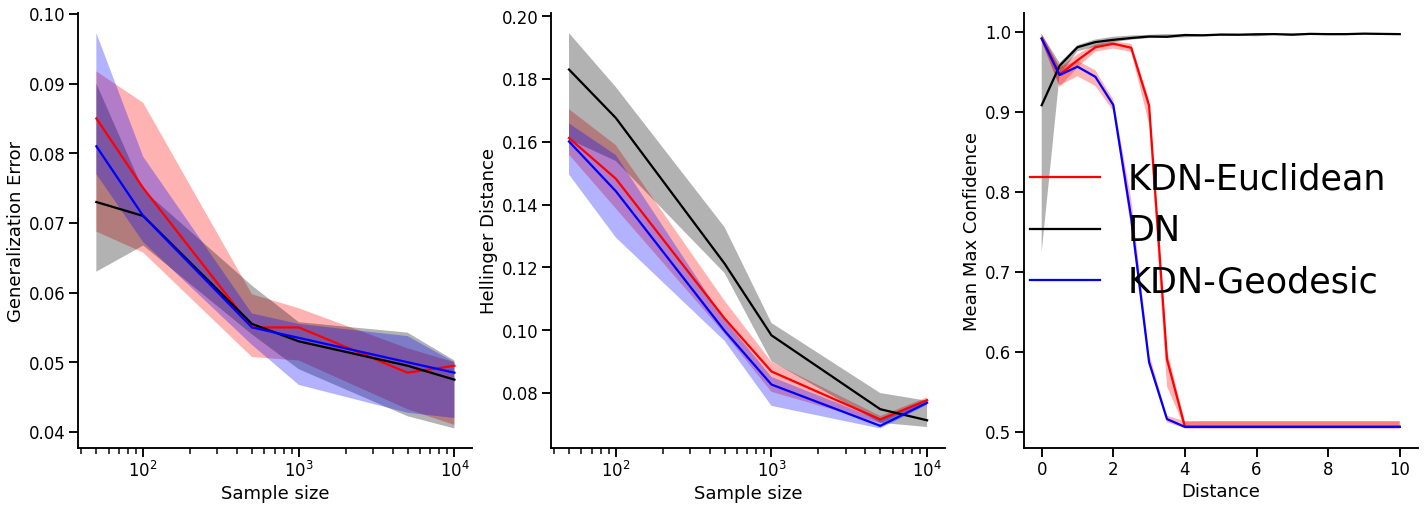

In [17]:
sample_size = [50, 100, 500, 1000, 5000, 10000]

sns.set_context('talk')
fig, ax = plt.subplots(1,3, figsize=(24,8))


ax[0].plot(sample_size, df['error_kdn_med'], c="r", label='KDN-Euclidean')
ax[0].plot(sample_size, df['error_dn_med'], c="k", label='DN')
ax[0].plot(sample_size, df['error_kdn_geod_med'], c="b", label='KDN-Geodesic')

ax[0].fill_between(sample_size, df['error_kdn_25'], df['error_kdn_75'], facecolor='r', alpha=.3)
ax[0].fill_between(sample_size, df['error_dn_25'], df['error_dn_75'], facecolor='k', alpha=.3)
ax[0].fill_between(sample_size, df['error_kdn_geod_25'], df['error_kdn_geod_75'], facecolor='b', alpha=.3)

ax[0].set_xscale('log')
ax[0].set_xlabel('Sample size')
ax[0].set_ylabel('Generalization Error')

right_side = ax[0].spines["right"]
right_side.set_visible(False)
top_side = ax[0].spines["top"]
top_side.set_visible(False)




ax[1].plot(sample_size, df['hellinger_kdn_med'], c="r", label='KDN-Euclidean')
ax[1].plot(sample_size, df['hellinger_dn_med'], c="k", label='DN')
ax[1].plot(sample_size, df['hellinger_kdn_geod_med'], c="b", label='KDN-Geodesic')

ax[1].fill_between(sample_size, df['hellinger_kdn_25'], df['hellinger_kdn_75'], facecolor='r', alpha=.3)
ax[1].fill_between(sample_size, df['hellinger_dn_25'], df['hellinger_dn_75'], facecolor='k', alpha=.3)
ax[1].fill_between(sample_size, df['hellinger_kdn_geod_25'], df['hellinger_kdn_geod_75'], facecolor='b', alpha=.3)

ax[1].set_xscale('log')
ax[1].set_xlabel('Sample size')
ax[1].set_ylabel('Hellinger Distance')

right_side = ax[1].spines["right"]
right_side.set_visible(False)
top_side = ax[1].spines["top"]
top_side.set_visible(False)


r = np.arange(0,10.5,.5)
ax[2].plot(r, df['mmcOut_kdn_med'], c="r", label='KDN-Euclidean')
ax[2].plot(r, df['mmcOut_dn_med'], c="k", label='DN')
ax[2].plot(r, df['mmcOut_kdn_geod_med'], c="b", label='KDN-Geodesic')

ax[2].fill_between(r, df['mmcOut_kdn_25'].ravel(), df['mmcOut_kdn_75'].ravel(), facecolor='r', alpha=.3)
ax[2].fill_between(r, df['mmcOut_dn_25'].ravel(), df['mmcOut_dn_75'].ravel(), facecolor='k', alpha=.3)
ax[2].fill_between(r, df['mmcOut_kdn_geod_25'].ravel(), df['mmcOut_kdn_geod_75'].ravel(), facecolor='r', alpha=.3)

#ax[3].set_xscale('log')
ax[2].set_xlabel('Distance')
ax[2].set_ylabel('Mean Max Confidence')

ax[2].legend(fontsize=35, frameon=False)

right_side = ax[2].spines["right"]
right_side.set_visible(False)
top_side = ax[2].spines["top"]
top_side.set_visible(False)

### OOD detection metrics

In [78]:
def fpr_at_95_tpr(conf_t, conf_f):
    TPR = 95
    PERC = np.percentile(conf_t, 100-TPR)
    FP = np.sum(conf_f >=  PERC)
    FPR = np.sum(conf_f >=  PERC)/len(conf_f)
    return FPR, PERC

In [79]:
sample = 1000
reps = 10
n_test = 1000
true_labels = np.hstack((np.ones(n_test, ), np.zeros(n_test, )))

roc_dn = []
roc_kdn = []

fpr_dn = []
fpr_kdn = []
reps_list = []

for ii in range(reps):
    X, y = generate_gaussian_parity(sample)
    X_test, y_test = generate_gaussian_parity(n_test)
    X_ood = generate_ood_samples(n_test)

    
    nn = getNN(input_size=2, num_classes=2)
    history = nn.fit(X, keras.utils.to_categorical(y), **fit_kwargs)
    model_kdn = kdn(k=1, network=nn)
    model_kdn.fit(X, y)

    dn_in_conf = np.max(model_kdn.network.predict(X_test), axis=1)
    dn_out_conf = np.max(model_kdn.network.predict(X_ood), axis=1)
    dn_conf = np.hstack((dn_in_conf, dn_out_conf))
    roc_dn.append(
        roc_auc_score(true_labels, dn_conf)
    )
    fpr_dn.append(
        fpr_at_95_tpr(dn_in_conf, dn_out_conf)
    )
    
    

    kdn_in_conf = np.max(model_kdn.predict_proba(X_test), axis=1)
    kdn_out_conf = np.max(model_kdn.predict_proba(X_ood), axis=1)
    kdn_conf = np.hstack((kdn_in_conf, kdn_out_conf))
    roc_kdn.append(
        roc_auc_score(true_labels, kdn_conf)
    )
    fpr_kdn.append(
        fpr_at_95_tpr(kdn_in_conf, kdn_out_conf)
    )

    reps_list.append(ii)

2023-03-06 09:26:59.365859: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 129: early stopping
Calculating weight for  1000  samples


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:05<00:00,  7.98it/s]



 1/32 [..............................] - ETA: 2s

2023-03-06 09:29:19.360454: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step


2023-03-06 09:29:19.846879: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 59: early stopping
Calculating weight for  1000  samples


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:04<00:00,  8.01it/s]



 1/32 [..............................] - ETA: 2s

2023-03-06 09:31:31.755608: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step


2023-03-06 09:31:32.253041: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 31: early stopping
Calculating weight for  1000  samples


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [18:41<00:00,  1.12s/it]



 1/32 [..............................] - ETA: 2s

2023-03-06 09:50:17.663610: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step


2023-03-06 09:50:18.167306: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 92: early stopping
Calculating weight for  1000  samples


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [23:45<00:00,  1.43s/it]



 1/32 [..............................] - ETA: 2s

2023-03-06 10:14:14.191732: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step


2023-03-06 10:14:14.710628: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 76: early stopping
Calculating weight for  1000  samples


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:02<00:00,  8.16it/s]



 1/32 [..............................] - ETA: 2s

2023-03-06 10:16:26.411805: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step


2023-03-06 10:16:26.905171: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 50: early stopping
Calculating weight for  1000  samples


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:07<00:00,  7.83it/s]



 1/32 [..............................] - ETA: 2s

2023-03-06 10:18:41.104489: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step


2023-03-06 10:18:41.582798: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 114: early stopping
Calculating weight for  1000  samples


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:06<00:00,  7.93it/s]



 1/32 [..............................] - ETA: 2s

2023-03-06 10:21:01.282403: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step


2023-03-06 10:21:01.783859: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 36: early stopping
Calculating weight for  1000  samples


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:04<00:00,  8.06it/s]



 1/32 [..............................] - ETA: 2s

2023-03-06 10:23:10.871671: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step


2023-03-06 10:23:11.402165: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 56: early stopping
Calculating weight for  1000  samples


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:04<00:00,  8.03it/s]



 1/32 [..............................] - ETA: 2s

2023-03-06 10:25:23.137776: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step


2023-03-06 10:25:23.632406: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 29: early stopping
Calculating weight for  1000  samples


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:07<00:00,  7.84it/s]



 1/32 [..............................] - ETA: 2s

2023-03-06 10:27:35.285419: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step


In [80]:
# obtain the AUROC and FPR@95 scores

# AUROC
print("KDN AUROC = {:.3f} +/- {:.3f}".format(np.mean(roc_kdn), np.std(roc_kdn)))
print("DN AUROC = {:.3f} +/- {:.3f}".format(np.mean(roc_dn), np.std(roc_dn)))

KDN AUROC = 0.955 +/- 0.003
DN AUROC = 0.324 +/- 0.074


In [81]:
# FPR@95
print("KDN FPR@95 = {:.3f} +/- {:.3f}".format(np.mean(fpr_kdn), np.std(fpr_kdn)))
print("DN FPR@95 = {:.3f} +/- {:.3f}".format(np.mean(fpr_dn), np.std(fpr_dn)))

KDN FPR@95 = 0.504 +/- 0.356
DN FPR@95 = 0.910 +/- 0.081
